# Executive Summary

Attempt to classify forest areas based on available attributes using python & sklearn machine learnign library

Tested:
- RandomForrest classifier with binary features as scalars
- ExtraTrees classifier
- Feature engineering inspired by [this example]( http://nbviewer.ipython.org/github/aguschin/kaggle/blob/master/forestCoverType_featuresEngineering.ipynb)



In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('./train.csv', index_col=0)
df_test = pd.read_csv('./test.csv', index_col=0)
print df.shape, df_test.shape
print df.columns

(15120, 55) (565892, 54)
Index([u'Elevation', u'Aspect', u'Slope', u'Horizontal_Distance_To_Hydrology', u'Vertical_Distance_To_Hydrology', u'Horizontal_Distance_To_Roadways', u'Hillshade_9am', u'Hillshade_Noon', u'Hillshade_3pm', u'Horizontal_Distance_To_Fire_Points', u'Wilderness_Area1', u'Wilderness_Area2', u'Wilderness_Area3', u'Wilderness_Area4', u'Soil_Type1', u'Soil_Type2', u'Soil_Type3', u'Soil_Type4', u'Soil_Type5', u'Soil_Type6', u'Soil_Type7', u'Soil_Type8', u'Soil_Type9', u'Soil_Type10', u'Soil_Type11', u'Soil_Type12', u'Soil_Type13', u'Soil_Type14', u'Soil_Type15', u'Soil_Type16', u'Soil_Type17', u'Soil_Type18', u'Soil_Type19', u'Soil_Type20', u'Soil_Type21', u'Soil_Type22', u'Soil_Type23', u'Soil_Type24', u'Soil_Type25', u'Soil_Type26', u'Soil_Type27', u'Soil_Type28', u'Soil_Type29', u'Soil_Type30', u'Soil_Type31', u'Soil_Type32', u'Soil_Type33', u'Soil_Type34', u'Soil_Type35', u'Soil_Type36', u'Soil_Type37', u'Soil_Type38', u'Soil_Type39', u'Soil_Type40', u'Cover_Type'], 

# Data Discovery

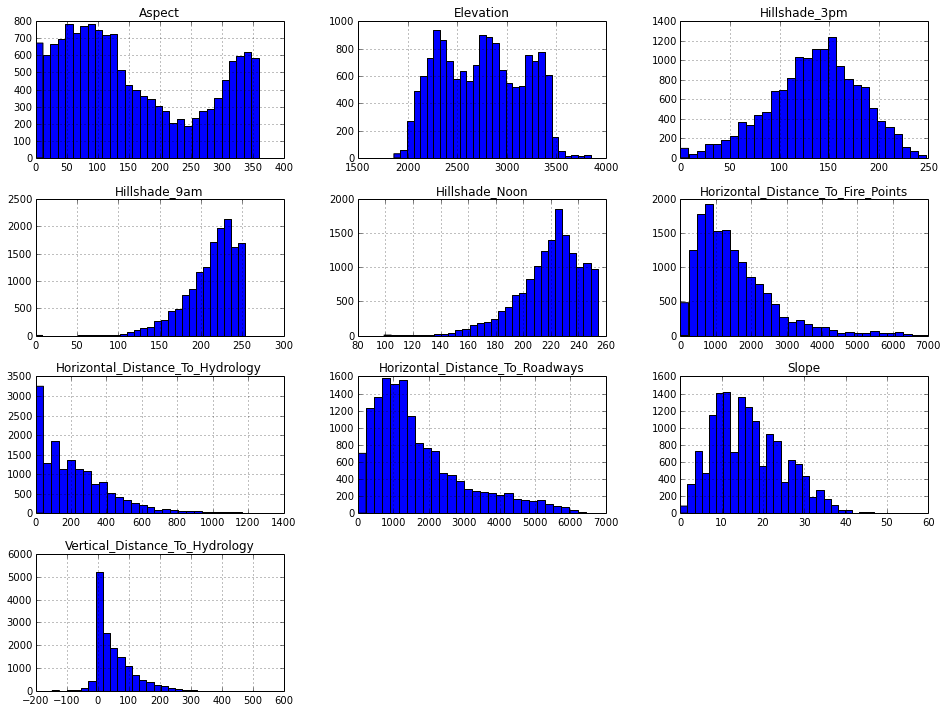

In [3]:
#plt.hist(df.Elevation.values, bins=20, cumulative=False)
df[df.columns[:10]].hist(figsize=(16,12), bins=30)
plt.show()

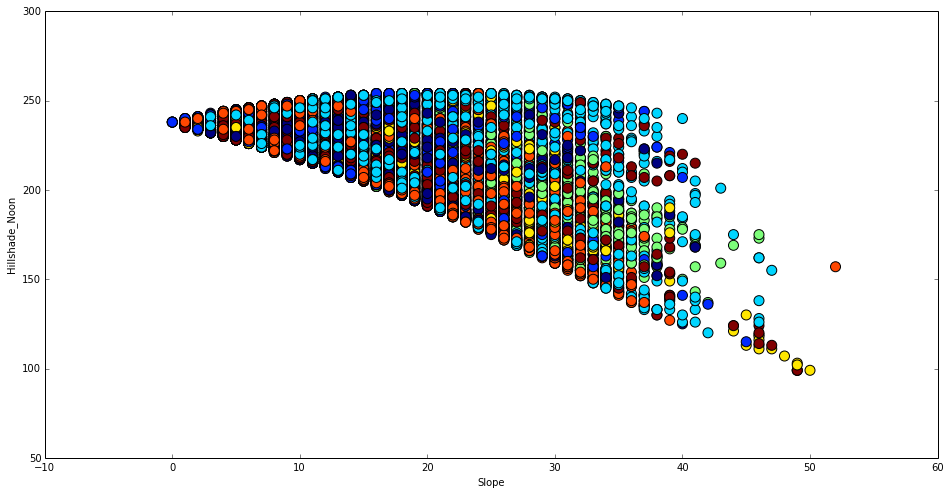

In [19]:
# @todo - how to use this relation - observe relation more with double partial dependence
custom_scatter(df, 'Slope', 'Hillshade_Noon')

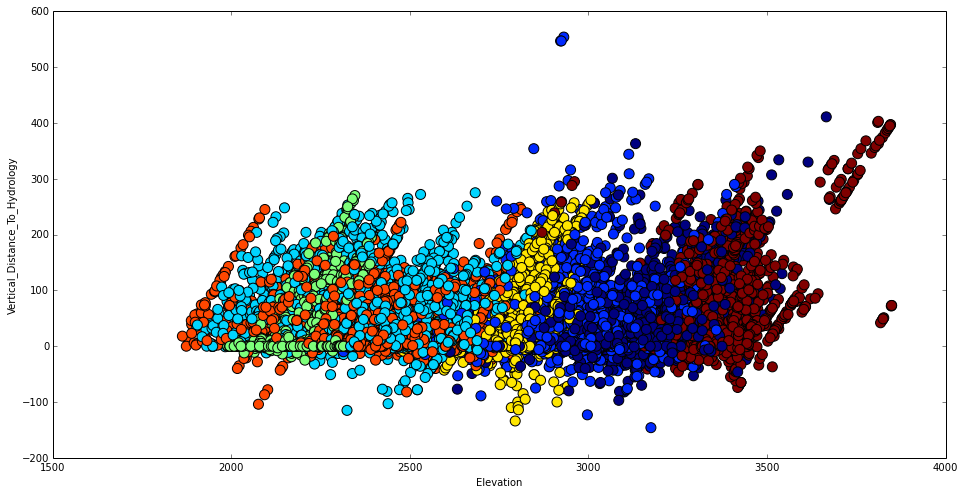

In [8]:
def custom_scatter(df_in, c1, c2):
    sel = np.array(list(df_in.Cover_Type.values))
    fig = plt.figure(figsize=(16,8))
    plt.scatter(df_in[c1], df_in[c2], marker='o', c=sel, s=100)
    plt.xlabel(c1)
    plt.ylabel(c2)
    

criterion = df.Cover_Type.map(lambda x: x in [1,2,3,4,5,6,7] )
custom_scatter(df[ criterion ], 'Elevation', 'Vertical_Distance_To_Hydrology')

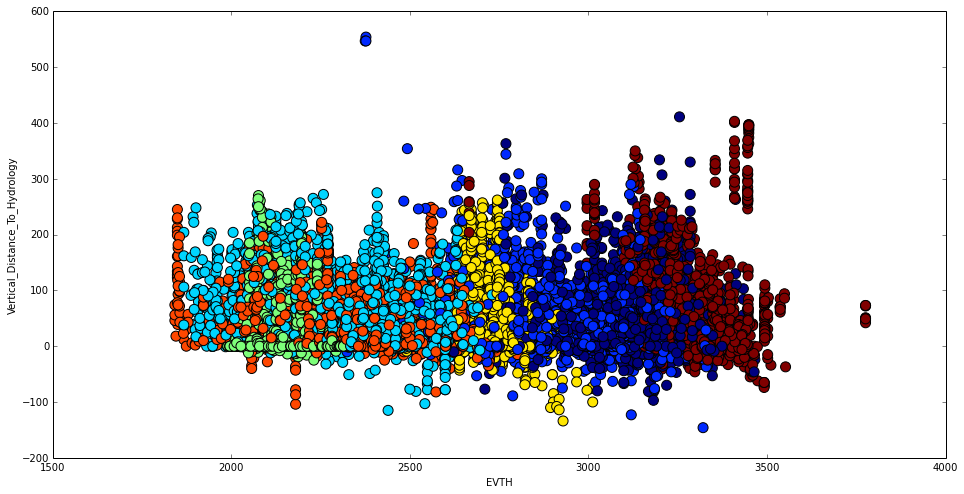

In [6]:
df['EVTH'] = df.Elevation - df.Vertical_Distance_To_Hydrology
custom_scatter(df, 'EVTH', 'Vertical_Distance_To_Hydrology')

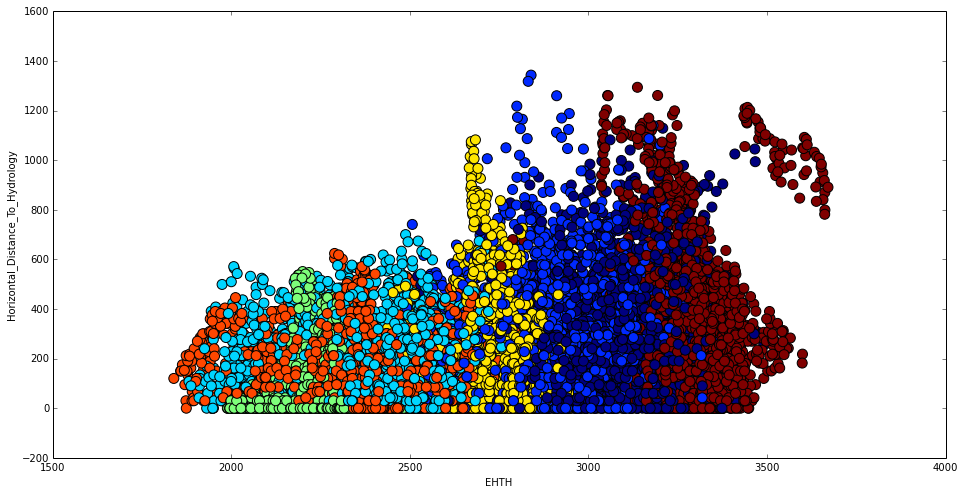

In [7]:
df['EHTH'] = df.Elevation - df.Horizontal_Distance_To_Hydrology * 0.2
custom_scatter(df[ criterion ], 'EHTH', 'Horizontal_Distance_To_Hydrology')

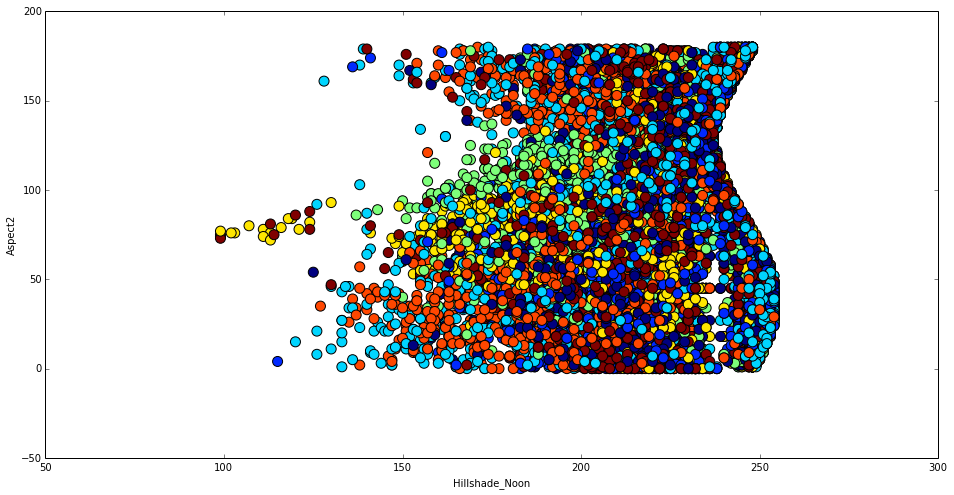

In [10]:
df['DFR'] = df.Horizontal_Distance_To_Fire_Points * 0.05 - df.Horizontal_Distance_To_Roadways
df['Aspect2'] = df.Aspect.map(get_aspect2)
custom_scatter(df[ criterion ], 'Hillshade_Noon', 'Aspect2')

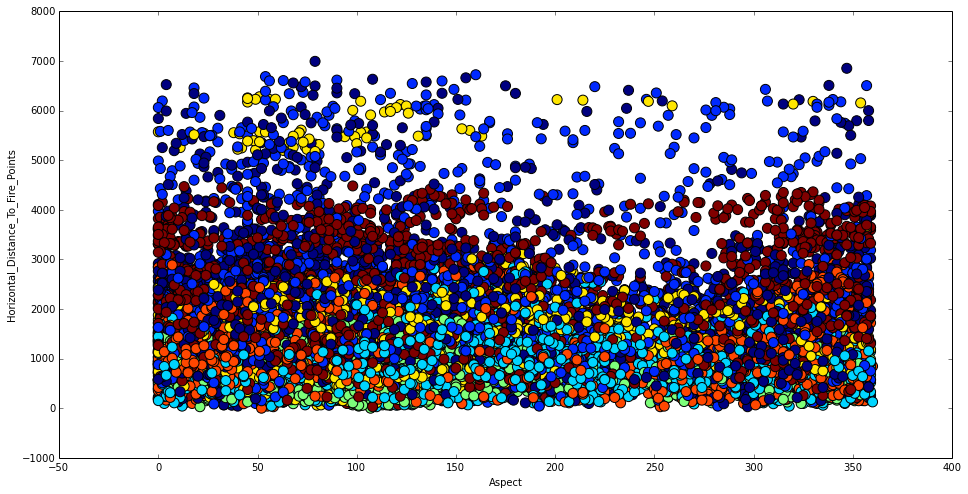

In [543]:
custom_scatter(df[ criterion ], 'Aspect', 'Horizontal_Distance_To_Fire_Points')

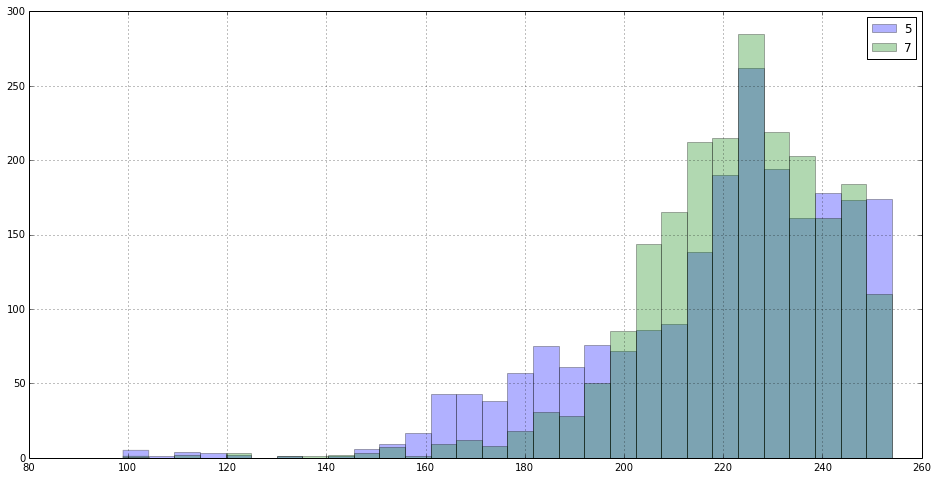

In [27]:
#df['Distance_To_Hydrology'] = np.sqrt( np.square(df.Horizontal_Distance_To_Hydrology) + np.square(df.Vertical_Distance_To_Hydrology) )
#df.Cover_Type[df.Vertical_Distance_To_Hydrology > 200].value_counts()
#plt.plot(df.Elevation[df.Cover_Type == 1], 'b.')
col_observed = 'Hillshade_Noon'
fig = plt.figure(figsize=(16,8))
#for val in range(1,8):
#for val in [1,2,3,4,5,6,7]:
for val in [5,7]:
    df[df.Cover_Type==val][col_observed].hist(bins=30,alpha=0.3, label=str(val))
plt.legend()

In [134]:
'''Each binary group - One and only one value for each observation'''
aux = df[['Soil_Type'+str(x) for x in range(1,41)]]
print 'soil type:', aux.as_matrix().sum(axis=1).sum()
aux = df[['Wilderness_Area'+str(x) for x in range(1,5)]]
print 'wilderness area:', aux.as_matrix().sum(axis=1).sum()
print df.columns[54]

soil type: 15120
wilderness area: 15120
Cover_Type


# Feature Engineering

In [3]:
def convert_from_binary(args):
    '''convert binary data into scalar value'''
    i = 0
    for x in args:
        if x:
            return i
        i += 1

def get_aspect2(x):
    if x > 180:
        x -= 180
    return x
        
def prep_data_rfc(df_in):
    '''prepare data for random forest Classifier
    - no scaling
    - join binary values to scalar value
    '''
    df_out = df_in[df_in.columns[:10]]
    
    df_out['Distance_To_Hydrology'] = np.sqrt( np.square(df_in.Horizontal_Distance_To_Hydrology) + np.square(df_in.Vertical_Distance_To_Hydrology) )
    
    df_out['Mean_Hillshade'] = (df_in.Hillshade_3pm + df_in.Hillshade_9am + df_in.Hillshade_Noon) / 3
    
    df_out['EVTH'] = df_in.Elevation - df_in.Vertical_Distance_To_Hydrology
    df_out['EHTH'] = df_in.Elevation - df_in.Horizontal_Distance_To_Hydrology * 0.2
    df_out['DFR'] = df_in.Horizontal_Distance_To_Fire_Points * 0.05 - df_in.Horizontal_Distance_To_Roadways
    df['Aspect2'] = df.Aspect.map(get_aspect2)
    
    # Wilderness_area1 .. Wilderness_area4
    df_out['Wilderness_Area'] = df_in[df_in.columns[10:14]].apply(convert_from_binary, axis=1)
    # Soil_Type1 .. Soil_Type40
    df_out['Soil_Type'] = df_in[df_in.columns[14:54]].apply(convert_from_binary, axis=1)
    return df_out        
        
def prep_data_rfc_pca(df_in, n_components):
    '''prepare data for random forest Classifier
    - no scaling
    - join binary values to scalar value
    '''
    # PCA
    pca = PCA(n_components=n_components)
    df_out = pd.DataFrame( pca.fit_transform( df_in[df_in.columns[:10]] ), columns=['pca'+str(i) for i in range(n_components)], index=df_in.index) 
    # Wilderness_area1 .. Wilderness_area4
    df_out['Wilderness_Area'] = df_in[df_in.columns[10:14]].apply(convert_from_binary, axis=1)
    # Soil_Type1 .. Soil_Type40
    df_out['Soil_Type'] = df_in[df_in.columns[14:54]].apply(convert_from_binary, axis=1)
    return df_out

def pre_data_svm(df_in):
    df_out = pd.DataFrame(scale(df_in[df_in.columns[:10]], axis=0), columns=df_in.columns[:10], index=df_in.index)
    # Wilderness_area1 .. Wilderness_area4
    df_out['Wilderness_Area'] = df_in[df_in.columns[10:14]].apply(convert_from_binary, axis=1)
    # Soil_Type1 .. Soil_Type40
    #df_out = df_out.join(df_in[df_in.columns[14:54]].apply(convert_from_binary, axis=1))
    df_out['Soil_Type'] = df_in[df_in.columns[14:54]].apply(convert_from_binary, axis=1)
    return df_out

# Classification Algos

In [28]:
'''
Score: 0.805687830688 {'n_estimators': 100}
GradientBoostingClassifier - performs worse than forest/tree
- could try GBC for each class and then collect results
'''
clf = RandomForestClassifier()
#clf = ExtraTreesClassifier()
#clf = GradientBoostingClassifier()
#best_parameters = {'n_estimators' : 35, 'max_features' : 17, 'min_samples_split' : 3, \
#'min_samples_leaf' : 3, 'bootstrap' : False, 'criterion': "entropy"}

param_grid = {'n_estimators': [100], 'max_features': [10,'auto', 17], 'min_samples_split': [2,3,5,9],
             'min_samples_leaf': [1,3], 'bootstrap':[True, False], 'criterion':['entropy', 'gini']}
#param_grid = {}
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=3)
grid_search.fit(prep_data_rfc(df), df.Cover_Type)

print 'Score:', grid_search.best_score_, grid_search.best_params_

Score: 0.799867724868 {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 100, 'min_samples_split': 5, 'criterion': 'entropy', 'max_features': 'auto'}


In [241]:
pca = PCA(n_components=3)
pca.fit(df[df.columns[:10]])
pca.explained_variance_ratio_
pca.transform( df[df.columns[:10]] ).shape

(15120, 3)

In [20]:
#list top attributes
import operator
arr = zip(prep_data_rfc(df).columns, grid_search.best_estimator_.feature_importances_)
sorted(arr, key=operator.itemgetter(1), reverse=True)

[('EVTH', 0.15079896531327328),
 ('EHTH', 0.12963201491771478),
 ('Soil_Type', 0.11186647951638473),
 ('Horizontal_Distance_To_Fire_Points', 0.10475241347945624),
 ('Elevation', 0.1004088637393874),
 ('DFR', 0.088600111097774339),
 ('Horizontal_Distance_To_Roadways', 0.052340692089734117),
 ('Hillshade_9am', 0.045076953255320754),
 ('Wilderness_Area', 0.036466579454711899),
 ('Hillshade_Noon', 0.030140571770352675),
 ('Distance_To_Hydrology', 0.02706143435013654),
 ('Vertical_Distance_To_Hydrology', 0.026193925905169117),
 ('Aspect', 0.02617308683876873),
 ('Hillshade_3pm', 0.025283218856980417),
 ('Mean_Hillshade', 0.01669636136642786),
 ('Horizontal_Distance_To_Hydrology', 0.014634959818502198),
 ('Slope', 0.01387336822990492)]

In [17]:
print prep_data_rfc(df).columns
print len(prep_data_rfc(df).columns)

Index([u'Elevation', u'Aspect', u'Slope', u'Horizontal_Distance_To_Hydrology', u'Vertical_Distance_To_Hydrology', u'Horizontal_Distance_To_Roadways', u'Hillshade_9am', u'Hillshade_Noon', u'Hillshade_3pm', u'Horizontal_Distance_To_Fire_Points', u'Distance_To_Hydrology', u'Mean_Hillshade', u'EVTH', u'EHTH', u'DFR', u'Wilderness_Area', u'Soil_Type'], dtype='object')
17


In [55]:
#aux = prep_data_rfc(df)
indx = aux.EVTH > 2900
df.Cover_Type[indx].value_counts()

7    2153
1    1921
2     980
5     102
dtype: int64

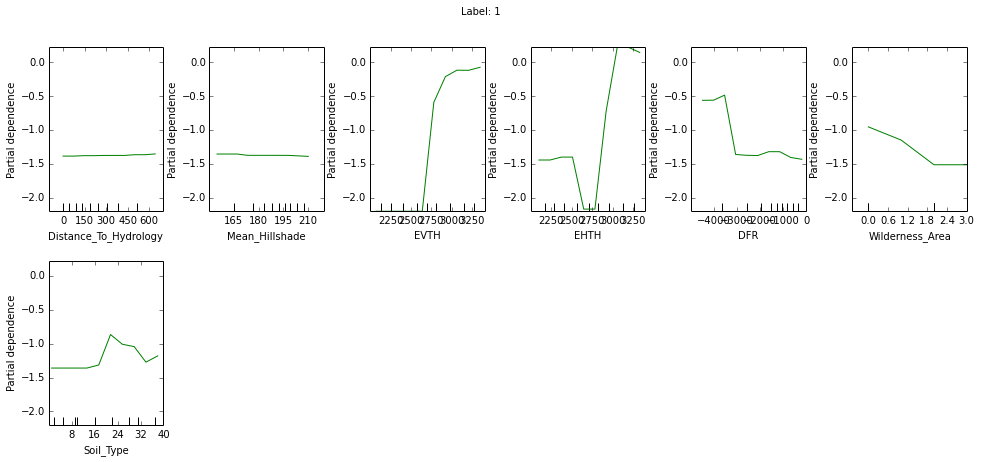

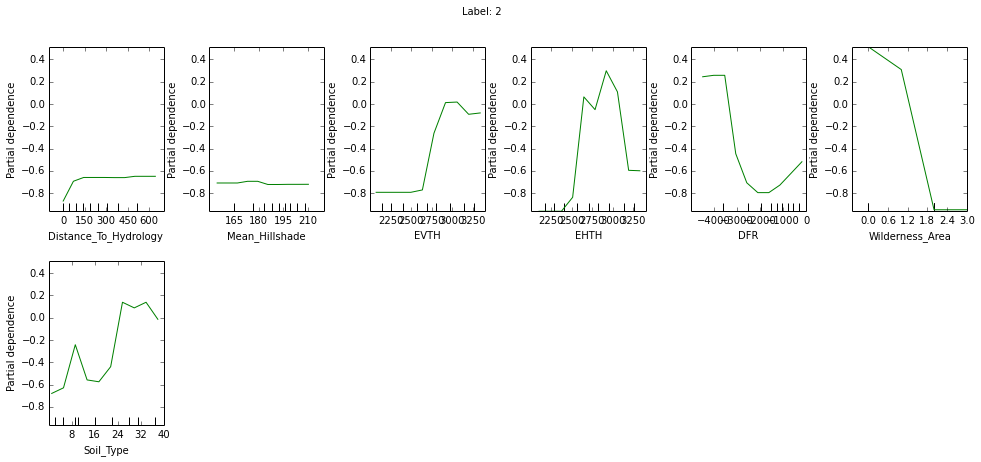

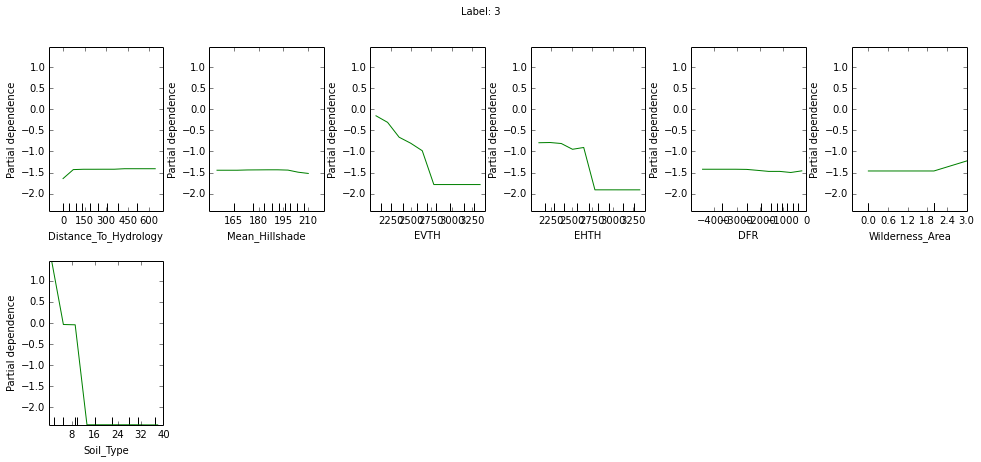

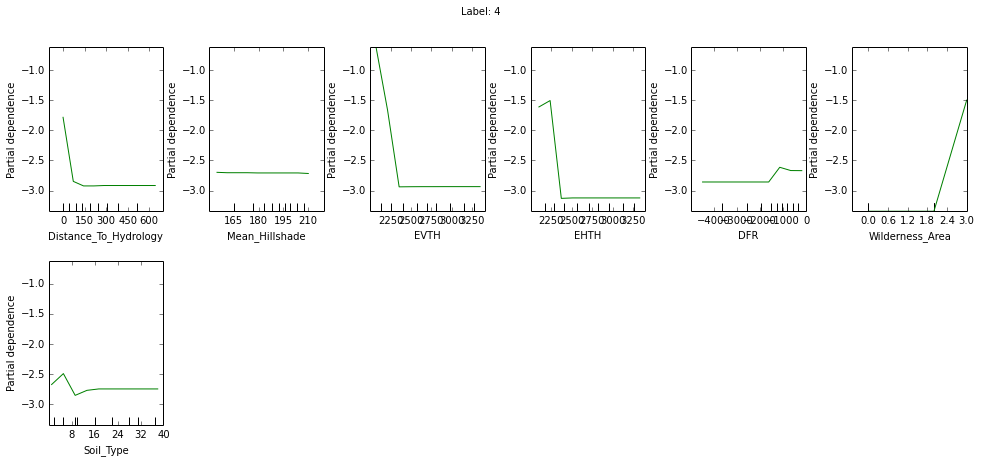

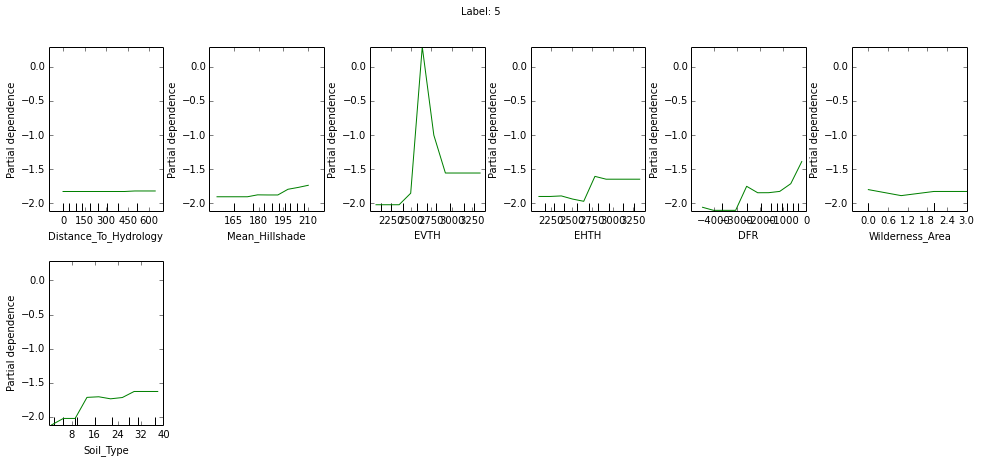

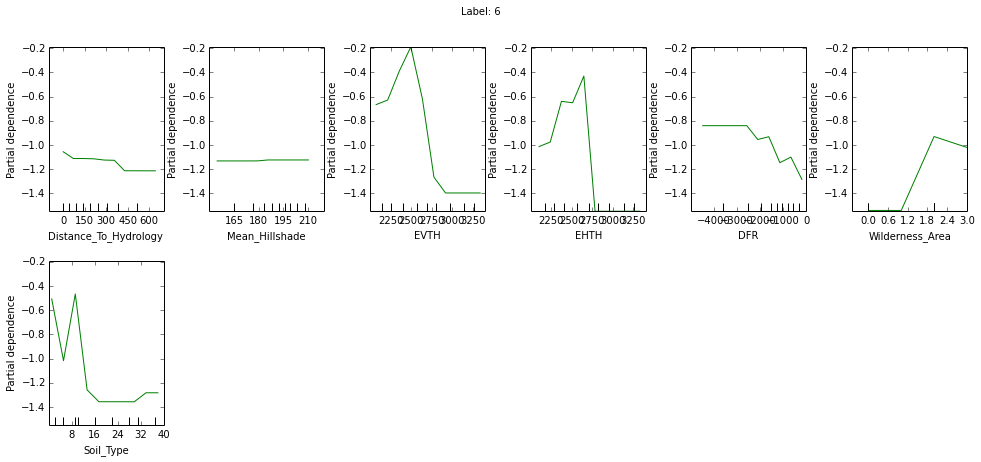

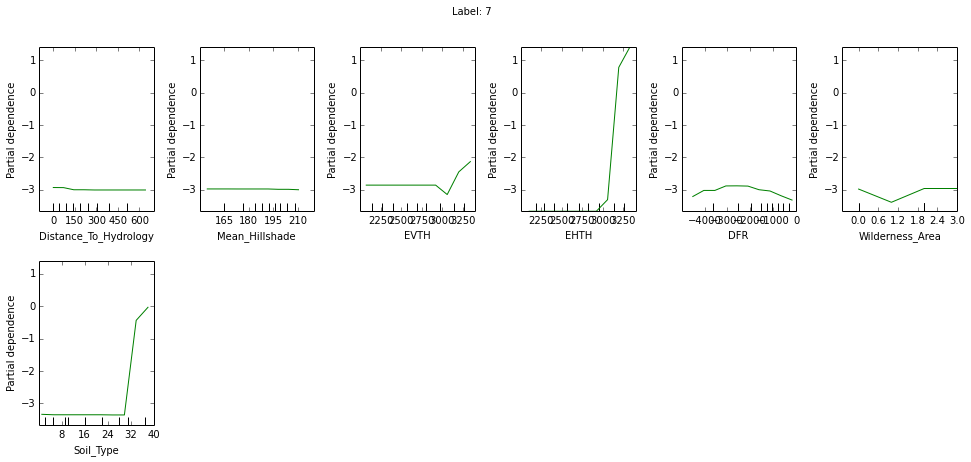

In [96]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence, partial_dependence

for label in range(1,8):
    features = range(10,17)
    fig, axs = plot_partial_dependence(grid_search.best_estimator_, aux, features, n_cols=6,
                        feature_names=aux.columns, label=label, grid_resolution=10)
    fig.suptitle('Label: ' + str(label))
    fig.set_size_inches(15,7)

    fig.subplots_adjust(top=0.9)
    

# Output

In [530]:
prediction = grid_search.best_estimator_.predict( prep_data_rfc( df_test ) )
pass

In [531]:
pd.Series(prediction, index=df_test.index).to_csv('./result2.csv', header=['Cover_Type'])

In [417]:
df.columns[:-1]

Index([u'Elevation', u'Aspect', u'Slope', u'Horizontal_Distance_To_Hydrology', u'Vertical_Distance_To_Hydrology', u'Horizontal_Distance_To_Roadways', u'Hillshade_9am', u'Hillshade_Noon', u'Hillshade_3pm', u'Horizontal_Distance_To_Fire_Points', u'Wilderness_Area1', u'Wilderness_Area2', u'Wilderness_Area3', u'Wilderness_Area4', u'Soil_Type1', u'Soil_Type2', u'Soil_Type3', u'Soil_Type4', u'Soil_Type5', u'Soil_Type6', u'Soil_Type7', u'Soil_Type8', u'Soil_Type9', u'Soil_Type10', u'Soil_Type11', u'Soil_Type12', u'Soil_Type13', u'Soil_Type14', u'Soil_Type15', u'Soil_Type16', u'Soil_Type17', u'Soil_Type18', u'Soil_Type19', u'Soil_Type20', u'Soil_Type21', u'Soil_Type22', u'Soil_Type23', u'Soil_Type24', u'Soil_Type25', u'Soil_Type26', u'Soil_Type27', u'Soil_Type28', u'Soil_Type29', u'Soil_Type30', u'Soil_Type31', u'Soil_Type32', u'Soil_Type33', u'Soil_Type34', u'Soil_Type35', u'Soil_Type36', u'Soil_Type37', u'Soil_Type38', u'Soil_Type39', u'Soil_Type40'], dtype='object')